<a href="https://colab.research.google.com/github/FrancisDcruz/OpenFairness/blob/main/crime_fareness_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install aif360

     |████████████████████████████████| 174kB 2.7MB/s 


In [2]:
import pandas as pd 
from numpy import nan
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
#from sklego.linear_model import DemographicParityClassifier
#from sklego.metrics import p_percent_score
from sklearn.model_selection import cross_val_score
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [3]:
from google.colab import files
files.upload() 

Saving Daily_Inmates_In_Custody.csv to Daily_Inmates_In_Custody.csv


{'Daily_Inmates_In_Custody.csv': b'INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION\r\n20209345,2/15/2020,,MIN,Y,O,M,58,DE,N,N,117.62,N\r\n20149472,9/14/2020,,MIN,Y,B,M,30,DE,N,N,120.1,N\r\n133023,8/24/2018,,MAX,Y,B,M,42,DE,N,N,125.25,Y\r\n20029823,01/06/2019,,MAX,Y,B,M,36,DE,N,N,135.2,Y\r\n20211644,10/15/2020,,MED,N,W,M,52,DE,N,N,220.21,N\r\n122980,10/22/2020,,MED,N,B,M,37,DEP,N,N,,N\r\n20019267,3/14/2020,,MAX,Y,B,M,28,DE,N,Y,120.1,Y\r\n20009388,10/13/2020,,MAX,Y,B,M,32,DEP,N,N,160.1,N\r\n20057663,2/14/2018,,MED,N,B,M,51,DE,N,N,125.25,Y\r\n20036616,6/24/2019,,MAX,Y,B,M,39,DE,N,Y,230.34,Y\r\n20196814,7/19/2018,,MAX,N,B,M,21,DE,N,Y,125.25,Y\r\n20126766,12/06/2019,,MED,N,B,M,29,DE,N,N,130.96,Y\r\n20192843,9/27/2020,,MAX,N,W,M,36,DE,N,N,160.15,N\r\n20207687,1/25/2020,,MAX,Y,W,M,28,DE,N,Y,125.25,Y\r\n20211077,09/06/2020,,MIN,Y,O,M,28,DE,N,N,150.2,N\r\n20209165,02/01/2020,,MED,Y,A,M,25,DE,N,N,125.25,N\r\n20017335,08/0

Daily inmates in custody with attributes (custody level, mental health designation, race, gender, age, leagal status, sealed status, security risk group membership, top charge, and infraction flag)

The Bradh in the column mentions whether the inmates is under mental observation.
This model tries to predict if a particular inmate is under mental obervation or not

In [84]:
data=pd.read_csv('/content/Daily_Inmates_In_Custody.csv')

In [85]:
data.head()

,INMATEID,ADMITTED_DT,DISCHARGED_DT,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SEALED,SRG_FLG,TOP_CHARGE,INFRTION
0,20209345,2/15/2020,NaN,MIN,Y,O,M,58.0,DE,N,N,117.62,N
1,20149472,9/14/2020,NaN,MIN,Y,B,M,30.0,DE,N,N,120.10,N
2,133023,8/24/2018,NaN,MAX,Y,B,M,42.0,DE,N,N,125.25,Y
3,20029823,01/06/2019,NaN,MAX,Y,B,M,36.0,DE,N,N,135.20,Y
4,20211644,10/15/2020,NaN,MED,N,W,M,52.0,DE,N,N,220.21,N


In [86]:
data.drop(data.columns[[0,1,2]],axis=1,inplace=True)
data.drop(columns=['SEALED'],axis=1,inplace=True)

In [87]:
data.head()

,CUSTODY_LEVEL,BRADH,RACE,GENDER,AGE,INMATE_STATUS_DE,SRG_FLG,TOP_CHARGE,INFRTION
0,MIN,Y,O,M,58.0,DE,N,117.62,N
1,MIN,Y,B,M,30.0,DE,N,120.10,N
2,MAX,Y,B,M,42.0,DE,N,125.25,Y
3,MAX,Y,B,M,36.0,DE,N,135.20,Y
4,MED,N,W,M,52.0,DE,N,220.21,N


In [88]:
data.nunique()

CUSTODY_LEVEL         3
BRADH                 2
RACE                  6
GENDER                2
AGE                  61
INMATE_STATUS_DE      8
SRG_FLG               2
TOP_CHARGE          169
INFRTION              2
dtype: int64

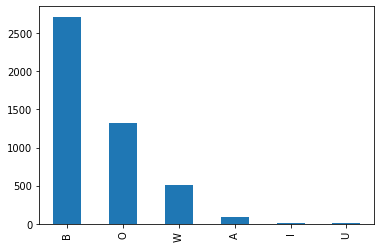

In [89]:
data['RACE'].value_counts().plot(kind='bar')

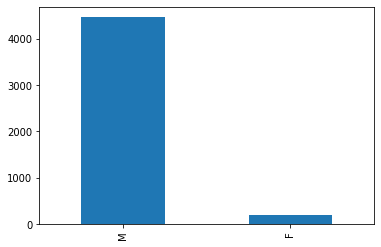

In [90]:
data['GENDER'].value_counts().plot(kind='bar')

On the Basic of the  above graphs we see that there Race and Gender are sensitive features which can cause bias in the prediction 

In [91]:
data['TOP_CHARGE'] = pd.to_numeric(data['TOP_CHARGE'], downcast="float")
data['TOP_CHARGE'].fillna(value=data['TOP_CHARGE'].mean(), inplace=True)

In [92]:
'''cols=['CUSTODY_LEVEL','RACE','GENDER','AGE']
data['CUSTODY_LEVEL'].fillna(lambda x: random.choice(data[data['CUSTODY_LEVEL'] != np.nan]['CUSTODY_LEVEL']), inplace =True)
data['RACE'].fillna(lambda x: random.choice(data[data['RACE'] != np.nan]['RACE']), inplace =True)
data['GENDER'].fillna(lambda x: random.choice(data[data['GENDER'] != np.nan]['GENDER']), inplace =True)
data['AGE'].fillna(lambda x: random.choice(data[data['AGE'] != np.nan]['AGE']), inplace =True)'''

"cols=['CUSTODY_LEVEL','RACE','GENDER','AGE']\ndata['CUSTODY_LEVEL'].fillna(lambda x: random.choice(data[data['CUSTODY_LEVEL'] != np.nan]['CUSTODY_LEVEL']), inplace =True)\ndata['RACE'].fillna(lambda x: random.choice(data[data['RACE'] != np.nan]['RACE']), inplace =True)\ndata['GENDER'].fillna(lambda x: random.choice(data[data['GENDER'] != np.nan]['GENDER']), inplace =True)\ndata['AGE'].fillna(lambda x: random.choice(data[data['AGE'] != np.nan]['AGE']), inplace =True)"

In [93]:
data.isna().sum()

CUSTODY_LEVEL       48
BRADH                0
RACE                 3
GENDER               3
AGE                  1
INMATE_STATUS_DE     0
SRG_FLG              0
TOP_CHARGE           0
INFRTION             0
dtype: int64

In [94]:
data=data.dropna()

In [95]:
data.columns

Index(['CUSTODY_LEVEL', 'BRADH', 'RACE', 'GENDER', 'AGE', 'INMATE_STATUS_DE',
       'SRG_FLG', 'TOP_CHARGE', 'INFRTION'],
      dtype='object')

In [96]:
data=pd.get_dummies(data, columns=['CUSTODY_LEVEL','GENDER', 'INMATE_STATUS_DE','SRG_FLG','INFRTION'])
data['BRADH'] = data['BRADH'].astype('category')
data['BRADH'] = data['BRADH'].cat.codes

In [97]:
data.loc[(data.RACE != 'B'),'RACE']='O'

In [98]:
data['RACE'] = data['RACE'].astype('category')
data['RACE'] = data['RACE'].cat.codes

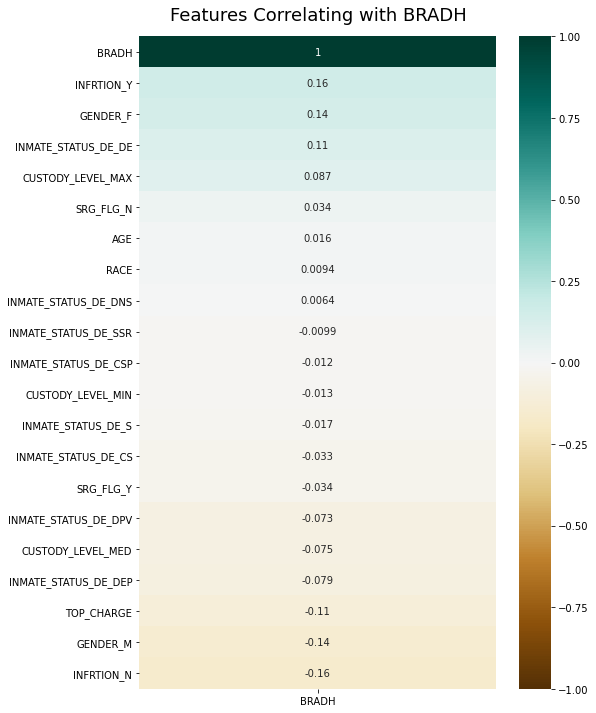

In [99]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['BRADH']].sort_values(by='BRADH', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with BRADH', fontdict={'fontsize':18}, pad=16);

In [100]:
df1 = data.pop('BRADH') # remove column b and store it in df1
data['mental_status']=df1 # add b series as a 'new' column.

In [101]:
data.head()

,RACE,AGE,TOP_CHARGE,CUSTODY_LEVEL_MAX,CUSTODY_LEVEL_MED,CUSTODY_LEVEL_MIN,GENDER_F,GENDER_M,INMATE_STATUS_DE_CS,INMATE_STATUS_DE_CSP,INMATE_STATUS_DE_DE,INMATE_STATUS_DE_DEP,INMATE_STATUS_DE_DNS,INMATE_STATUS_DE_DPV,INMATE_STATUS_DE_S,INMATE_STATUS_DE_SSR,SRG_FLG_N,SRG_FLG_Y,INFRTION_N,INFRTION_Y,mental_status
0,1,58.0,117.620003,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1
1,0,30.0,120.099998,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1
2,0,42.0,125.250000,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1
3,0,36.0,135.199997,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1
4,1,52.0,220.210007,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0


In [102]:
fair_data=data

In [103]:
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [104]:
from sklearn.model_selection import train_test_split
x_test,x_train,y_test, y_train=train_test_split(x,y, test_size=0.30,random_state=0)

In [105]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x= sc.fit_transform(x_train)

# **Predictions before performing fairness transformation**


Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0,max_iter=1000)
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)


#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.60 (+/- 0.08)


In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[ 806  720]
 [ 568 1133]]


0.6008676789587852

KNN

In [108]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.55 (+/- 0.02)


In [109]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[774 752]
 [710 991]]


0.5469476293771305

SVC

In [110]:
from sklearn.svm import SVC
classifier= SVC(kernel='linear', random_state= 0)
classifier.fit(x_train,y_train)
y_pred= classifier.predict(x_test)


#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.58 (+/- 0.08)


In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[935 591]
 [726 975]]


0.5918810040285094

Naive Bayes


In [112]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.53 (+/- 0.11)


In [113]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[1507   19]
 [1581  120]]


0.5041834521227146

Random Forest

In [114]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.55 (+/- 0.07)


In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[861 665]
 [748 953]]


0.5621320111558723

Decision Tree

In [116]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred= classifier.predict(x_test)

#Cross Validation
scores = cross_val_score(classifier, x_train, y_train, cv=5)
print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

 CV Accuracy: 0.52 (+/- 0.04)


In [117]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[827 699]
 [743 958]]


0.5531453362255966

# **Accuracy of models on original Data**

**Summary**

Logistic Regression:  
CV Accuracy: 0.60 (+/- 0.08),
Unseen Data prediction- 0.60





SVC:  
CV Accuracy: 0.58 (+/- 0.08),
Unseen Data prediction- 0.59

Random Forest:  
CV Accuracy: 0.55 (+/- 0.07),
Unseen Data prediction- 0.56

KNN:  
CV Accuracy: 0.55 (+/- 0.02),
Unseen Data prediction- 0.54

Naive Bayes:  
CV Accuracy: 0.53 (+/- 0.11), 
Unseen Data prediction- 0.50

Decision Tree:  
CV Accuracy: 0.52 (+/- 0.04),
Unseen Data prediction- 0.55

# Fairness Model Implementation 

In [123]:
fair_data.head()

,RACE,AGE,TOP_CHARGE,CUSTODY_LEVEL_MAX,CUSTODY_LEVEL_MED,CUSTODY_LEVEL_MIN,GENDER_F,GENDER_M,INMATE_STATUS_DE_CS,INMATE_STATUS_DE_CSP,INMATE_STATUS_DE_DE,INMATE_STATUS_DE_DEP,INMATE_STATUS_DE_DNS,INMATE_STATUS_DE_DPV,INMATE_STATUS_DE_S,INMATE_STATUS_DE_SSR,SRG_FLG_N,SRG_FLG_Y,INFRTION_N,INFRTION_Y,mental_status
0,1,58.0,117.620003,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1
1,0,30.0,120.099998,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1
2,0,42.0,125.250000,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1
3,0,36.0,135.199997,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1
4,1,52.0,220.210007,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0


For this time we consider Race as the sensitive feature with 1 being the privileged group and 0 being the unprivileged group

In [119]:
dataset_orig_train, dataset_orig_test = train_test_split(fair_data, test_size=0.30,random_state=0)
privileged_groups = [{'RACE': 1}] # Others race
unprivileged_groups = [{'RACE': 0}] # dark Race

In [120]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [122]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and \privileged groups = %f" % \
metric_orig_train.mean_difference())
Original training dataset 

'metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,\n                    unprivileged_groups=unprivileged_groups,\n                    privileged_groups=privileged_groups)\n\ndisplay(Markdown("#### Original training dataset"))\nprint("Difference in mean outcomes between unprivileged and \\privileged groups = %f" % metric_orig_train.mean_difference())\nOriginal training dataset '